# Настройки/Импорты

In [1]:
!pip install transformers==4.45.2
!pip install evaluate==0.4.3
!pip install seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import os # для взаимодействия с системой
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import random as random # для работы со случайностью
import pickle # для сохранения и загрузки объектов
from tqdm.auto import tqdm # для отслеживания прогресса

from datasets import Dataset, load_dataset, load_from_disk # для работы с HuggingFace датасетами

import torch # для работы с моделями torch
# from transformers import T5ForConditionalGeneration, T5Tokenizer # для работы с T5 моделью
from transformers import MT5ForConditionalGeneration, MT5Tokenizer # для работы с T5 моделью
from transformers import DataCollatorForSeq2Seq # для сборщика данных (чтобы)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer # для обучения модели
from transformers import EarlyStoppingCallback # callback для ранней остановки обучения

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
import seaborn as sns # для построения красивых графиков
import evaluate # для подсчёта метрик
from transformers.modelcard import parse_log_history # для парсинга логов обучения через Trainer

In [3]:
DATA_DIR = "/kaggle/working/data/" # путь до папки с данными
RESULTS_DIR = "/kaggle/working/results/" # путь до папки с результатами вычислений
EMBEDDING_DIR = "/kaggle/working/embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "/kaggle/working/models/" # путь до папки с моделями
MODEL_NAME = "cointegrated/rut5-base-multitask" # название модели для перевода
DATASET_NAME_HF = "aiana94/polynews-parallel"
DATASET_NAME_LOC = "polynews-parallel"

MAX_SEQUENCE_LEN = 256 # оптимальное число токенов в документе (если не достаёт — padding, если перебор — truncation), определялось по гистограмме распределения числа токенов в текстах

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
TEST_MAX_SAMPLES = 5000 # максимальное число тестовых примеров
TRAIN_MAX_SAMPLES = 30000 # максимальное число обучающих примеров

EPOCHS = 10 # число эпох обучения
EPOCHS_PATIENCE = 2 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
LEARNING_RATE = 0.00001 # learning rate
BATCH_SIZE = 14 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [4]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Девайс: {DEVICE}.")

Девайс: cuda:0.


# Подготовка данных и модели

In [5]:
model = MT5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.save_pretrained(MODELS_DIR + MODEL_NAME, from_pt=True) # сохранение модели
model

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

MT5ForConditionalGeneration(
  (shared): Embedding(30000, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(30000, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
           

In [6]:
tokenizer = MT5Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME) # сохранение токенизатора
tokenizer

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5Tokenizer(name_or_path='cointegrated/rut5-base-multitask', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
dataset = load_dataset(DATASET_NAME_HF, name="eng_Latn-rus_Cyrl") # скачивание датасета, name — название subset_а с HuggingFace
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC) # локальное сохранение датасета (в формате arrow)
dataset

README.md:   0%|          | 0.00/107k [00:00<?, ?B/s]

train.parquet.gzip:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'provenance'],
        num_rows: 176441
    })
})

In [8]:
dataset["train"][0]

{'src': 'Parliament Does Not Support Amendment Freeing Tymoshenko',
 'tgt': 'Парламент не поддерживает поправку, дающую свободу Тимошенко',
 'provenance': 'wmtnews'}

In [9]:
def preprocess_function(data: Dataset, random_state=RANDOM_STATE):
    random.seed(random_state) # Set the random number generator to a fixed sequence.
    samples_count = len(dataset["train"]) # общее число сэмплов в датасете

    reflected_idx = set(random.sample(range(0, samples_count), int(samples_count/2))) # индексы отражаемых сэмплов (set — для сортировки и удобного вычитания)
    regular_idx = set(range(0, samples_count)) - reflected_idx

    data["new_src"] = ["translate en-ru | " + sample if idx in regular_idx else "translate ru-en | " + data["tgt"][idx] for idx, sample in enumerate(data["src"])]
    data["new_tgt"] = [sample if idx in regular_idx else data["src"][idx] for idx, sample in enumerate(data["tgt"])]
    model_inputs = tokenizer(data["new_src"], text_target=data["new_tgt"], max_length=MAX_SEQUENCE_LEN, return_tensors="pt", truncation=True, padding=True)
    return model_inputs

In [10]:
dataset = dataset.map(preprocess_function, batched=True)
dataset = dataset.remove_columns(["provenance", "src", "tgt"]) # удаление ненужной колонки
dataset = dataset.rename_column("new_src", "src") # переименовываем колонку
dataset = dataset.rename_column("new_tgt", "tgt") # переименовываем колонку
dataset = dataset["train"].train_test_split(test_size=TEST_SIZE, shuffle=True, seed=RANDOM_STATE) # разбиение датасета на тестовую и обучающую выборки ()
dataset

Map:   0%|          | 0/176441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 141152
    })
    test: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35289
    })
})

In [11]:
dataset["train"][0]

{'src': "translate en-ru | Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. ",
 'tgt': "Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'input_ids': [9559,
  289,
  264,
  737,
  307,
  1011,
  358,
  1155,
  571,
  9972,
  1797,
  282,
  1401,
  265,
  277,
  263,
  3859,
  639,
  1282,
  259,
  23484,
  527,
  288,
  1692,
  4923,
  1373,
  260,
  3663,
  264,
  621,
  380,
  262,
  2346,
  639,
  13211,
  285,
  261,
  3524,
  790,
  259,
  7647,
  263,
  1000,
  1770,
  484,
  4429,
  347,
  259,
  14731,
  260,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [12]:
dataset.save_to_disk(DATA_DIR + DATASET_NAME_LOC + "_mt5_processed") # локальное сохранение датасета (в формате arrow)
# dataset = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_mt5_processed") # загрузка локально сохранённого датасета

Saving the dataset (0/1 shards):   0%|          | 0/141152 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35289 [00:00<?, ? examples/s]

# [Fine-tuning](https://huggingface.co/docs/transformers/tasks/translation) (с использованием PyTorch)

In [13]:
# model = MT5ForConditionalGeneration.from_pretrained(MODELS_DIR + MODEL_NAME) # загружаем предобученную модель
# tokenizer = MT5Tokenizer.from_pretrained(MODELS_DIR + MODEL_NAME) # загружаем предобученный токенизатор
dataset_tokenized = load_from_disk(DATA_DIR + DATASET_NAME_LOC + "_mt5_processed") # загрузка локально сохранённого датасета
metric_BLEU = evaluate.load("bleu") # загружаем метрику

In [14]:
params_all = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Число обучаемых параметров: {params_trainable} из {params_all}, то есть ~{params_trainable / params_all * 100:.2f}%.") # считаем число параметров

Число обучаемых параметров: 244309248 из 244309248, то есть ~100.00%.


Обрежим датасет, чтобы время обучения не составляло несколько дней.

In [15]:
dataset_tokenized["train"] = dataset_tokenized["train"].select(range(TRAIN_MAX_SAMPLES))
dataset_tokenized["test"] = dataset_tokenized["test"].select(range(TEST_MAX_SAMPLES))
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['src', 'tgt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

In [16]:
dataset_tokenized["train"][0]

{'src': "translate en-ru | Diaspora blogger Jumbie's Watch was also confused as to how Minister St. Rose-Greaves was spared, since he remembers her publicly accepting responsibility. ",
 'tgt': "Один из авторов блога Jumbie's Watch также был потрясен тем, как министр Сент-Роуз Гривз была избавлена от ответственности, хотя помнится она публично признала её. ",
 'input_ids': [9559,
  289,
  264,
  737,
  307,
  1011,
  358,
  1155,
  571,
  9972,
  1797,
  282,
  1401,
  265,
  277,
  263,
  3859,
  639,
  1282,
  259,
  23484,
  527,
  288,
  1692,
  4923,
  1373,
  260,
  3663,
  264,
  621,
  380,
  262,
  2346,
  639,
  13211,
  285,
  261,
  3524,
  790,
  259,
  7647,
  263,
  1000,
  1770,
  484,
  4429,
  347,
  259,
  14731,
  260,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="pt") # сборщик данных для обучения, return_tensors — тип возвращаемого тензора (pt — Torch, tf — Tensorflow, np — Numpy)

In [18]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

In [19]:
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    preds_decoded = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels_decoded = tokenizer.batch_decode(labels, skip_special_tokens=True)

    preds_decoded, labels_decoded = postprocess_text(preds_decoded, labels_decoded)

    result = metric_BLEU.compute(predictions=preds_decoded, references=labels_decoded)
    result = {"bleu": result["bleu"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["mean_len"] = np.mean(prediction_lens)
    result = {k: round(v, 5) for k, v in result.items()} # округляем float до 5 знаков после запятой
    return result

In [20]:
if not os.path.exists(RESULTS_DIR + MODEL_NAME):
    os.makedirs(RESULTS_DIR + MODEL_NAME)

## Обучение модели

In [21]:
# model = MT5ForConditionalGeneration.from_pretrained(MODEL_NAME)

In [22]:
model.generation_config.max_new_tokens = MAX_SEQUENCE_LEN
# model.to(torch.float32)

In [23]:
training_args = Seq2SeqTrainingArguments(
    output_dir=RESULTS_DIR + MODEL_NAME,
    # evaluation_strategy ="epoch",
    # evaluation_strategy="steps", # стратегия оценивания модели, "steps" - через несколько вызовов forward pass (нужен для работы EarlyStoping), "epoch" — по эпохам
    eval_strategy="steps",
    eval_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE), # подсчёт метрик и сохранение происходят каждые eval_steps шагов (нужно для работы для работы EarlyStoping), имитирующие одну эпоху
    save_strategy="steps", # стратегия сохранения модели, "steps" - через несколько вызовов forward pass (нужен для работы EarlyStoping), "epoch" — по эпохам
    save_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE), # для работы должен быть кратен eval_steps, если стратегии стоят как "steps"
    logging_strategy="steps", # стратегия подсчёта метрик на обучающей части
    logging_steps=int(dataset_tokenized["train"].shape[0] / BATCH_SIZE),
    learning_rate=LEARNING_RATE, # шаг обучения
    per_device_train_batch_size=BATCH_SIZE, # размер батча при обучении
    per_device_eval_batch_size=BATCH_SIZE, # размер батча при валидации
    weight_decay=0.01,
    save_total_limit=3, # количество сохраняемых чекпоинтов
    num_train_epochs=EPOCHS,
    predict_with_generate=True,
    
    # fp16=True, # проводить ли обучение в float16 вместо float32
    bf16=True, # проводить обучение в float16 от google (так обучены некоторые модели google и они не умеют работать с обычным fp16 из-за возникающих ошибок переполнения)
    
    load_best_model_at_end=True, # загружать ли в конце обучения чекпоинт с лучшей метрикой (также 100% сохраняет лучший чекпоинт)
    metric_for_best_model="eval_bleu", # название метрики, по которой будет определяться лучший чекпоинт обучения
    greater_is_better=True, # должна ли отслеживаемая метрика увеличиваться
    use_cpu=False, # использовать ли для подсчёта устройства, отличные от CPU
    push_to_hub=False,
    report_to="none" # не запускать wandb backend
)

In [24]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
    tokenizer=tokenizer, # tokenizer -> processing_class
    # processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EPOCHS_PATIENCE)] # callback_и для обучения, EarlyStoppingCallback — ранняя остановка
)

trainer.train()

Step,Training Loss,Validation Loss,Bleu,Mean Len
2142,0.621800,0.465419,0.116300,33.994200
4284,0.587300,0.451209,0.126840,34.285600
6426,0.569700,0.442614,0.133100,34.531400
8568,0.556200,0.436419,0.138180,34.895800
10710,0.547100,0.431884,0.140410,34.824800
12852,0.539400,0.428884,0.144260,35.047800
14994,0.534400,0.427570,0.146210,35.327800
17136,0.529600,0.425074,0.146590,34.926200
19278,0.527400,0.424487,0.147780,35.003800
21420,0.525900,0.424093,0.147940,34.951600


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=21430, training_loss=0.5538497487574162, metrics={'train_runtime': 38190.9735, 'train_samples_per_second': 7.855, 'train_steps_per_second': 0.561, 'total_flos': 9.54022240456704e+16, 'train_loss': 0.5538497487574162, 'epoch': 10.0})

In [25]:
trainer.model.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение модели
trainer.tokenizer.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение токенизатора
# trainer.processing_class.save_pretrained(MODELS_DIR + MODEL_NAME + "_finetuned", from_pt=True) # сохранение токенизатора

('/kaggle/working/models/cointegrated/rut5-base-multitask_finetuned/tokenizer_config.json',
 '/kaggle/working/models/cointegrated/rut5-base-multitask_finetuned/special_tokens_map.json',
 '/kaggle/working/models/cointegrated/rut5-base-multitask_finetuned/spiece.model',
 '/kaggle/working/models/cointegrated/rut5-base-multitask_finetuned/added_tokens.json')

In [26]:
trainer.state.log_history[:5]

[{'loss': 0.6218,
  'grad_norm': 0.530491054058075,
  'learning_rate': 9.00046663555763e-06,
  'epoch': 0.9995333644423705,
  'step': 2142},
 {'eval_loss': 0.46541857719421387,
  'eval_bleu': 0.1163,
  'eval_mean_len': 33.9942,
  'eval_runtime': 1456.9287,
  'eval_samples_per_second': 3.432,
  'eval_steps_per_second': 0.246,
  'epoch': 0.9995333644423705,
  'step': 2142},
 {'loss': 0.5873,
  'grad_norm': 0.538398027420044,
  'learning_rate': 8.00093327111526e-06,
  'epoch': 1.999066728884741,
  'step': 4284},
 {'eval_loss': 0.45120880007743835,
  'eval_bleu': 0.12684,
  'eval_mean_len': 34.2856,
  'eval_runtime': 1473.0039,
  'eval_samples_per_second': 3.394,
  'eval_steps_per_second': 0.243,
  'epoch': 1.999066728884741,
  'step': 4284},
 {'loss': 0.5697,
  'grad_norm': 0.6347987055778503,
  'learning_rate': 7.001399906672889e-06,
  'epoch': 2.9986000933271115,
  'step': 6426}]

In [27]:
history = parse_log_history(trainer.state.log_history)
history

({'train_runtime': 38190.9735,
  'train_samples_per_second': 7.855,
  'train_steps_per_second': 0.561,
  'total_flos': 9.54022240456704e+16,
  'train_loss': 0.5538497487574162,
  'epoch': 10.0,
  'step': 21430},
 [{'Training Loss': 0.6218,
   'Epoch': 0.9995333644423705,
   'Step': 2142,
   'Validation Loss': 0.46541857719421387,
   'Bleu': 0.1163,
   'Mean Len': 33.9942},
  {'Training Loss': 0.5873,
   'Epoch': 1.999066728884741,
   'Step': 4284,
   'Validation Loss': 0.45120880007743835,
   'Bleu': 0.12684,
   'Mean Len': 34.2856},
  {'Training Loss': 0.5697,
   'Epoch': 2.9986000933271115,
   'Step': 6426,
   'Validation Loss': 0.44261443614959717,
   'Bleu': 0.1331,
   'Mean Len': 34.5314},
  {'Training Loss': 0.5562,
   'Epoch': 3.998133457769482,
   'Step': 8568,
   'Validation Loss': 0.4364186227321625,
   'Bleu': 0.13818,
   'Mean Len': 34.8958},
  {'Training Loss': 0.5471,
   'Epoch': 4.997666822211853,
   'Step': 10710,
   'Validation Loss': 0.4318840205669403,
   'Bleu': 0.1

In [28]:
history = pd.DataFrame(history[1]) # преобразовываем историю обучения в DataFrame (данные на самом деле про test часть, хоть в них и не указано 'eval_')
history

,Training Loss,Epoch,Step,Validation Loss,Bleu,Mean Len
0,0.6218,0.999533,2142,0.465419,0.11630,33.9942
1,0.5873,1.999067,4284,0.451209,0.12684,34.2856
2,0.5697,2.998600,6426,0.442614,0.13310,34.5314
3,0.5562,3.998133,8568,0.436419,0.13818,34.8958
4,0.5471,4.997667,10710,0.431884,0.14041,34.8248
5,0.5394,5.997200,12852,0.428884,0.14426,35.0478
6,0.5344,6.996734,14994,0.427570,0.14621,35.3278
7,0.5296,7.996267,17136,0.425074,0.14659,34.9262
8,0.5274,8.995800,19278,0.424487,0.14778,35.0038
9,0.5259,9.995334,21420,0.424093,0.14794,34.9516


In [29]:
def plot_history(history):
    fig, axes = plt.subplots(ncols=3, figsize=(24,7)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

    # берём данные об обучении
    epochs = history["Epoch"].values
    loss_train = history["Training Loss"].values # значение loss при обучении
    loss_test = history["Validation Loss"].values # значение loss при валидации
    bleu_test = history["Bleu"].values # значение BLEU при валидации
    len_test = history["Mean Len"].values # среднее количество токенов предсказания при валидации
    best_epoch = bleu_test.argmax() + 1 # эпоха с наилучшей метрикой (+1 из-за нумерации с 0)

    axes[0].plot(epochs, loss_train, color="b", label="При обучении") # построение графика
    axes[0].plot(epochs, loss_test, color="r", label="При валидации") # построение графика
    axes[0].plot(best_epoch, loss_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[0].set_title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
    axes[0].set_xlabel("Эпоха") # подпись по оси OX
    axes[0].set_ylabel("Loss") # подпись по оси OY
    axes[0].grid(True) # отображение сетки на графике
    axes[0].legend() # отображение подписей графиков

    axes[1].plot(epochs, bleu_test, color="r", label="При валидации") # построение графика
    axes[1].plot(best_epoch, bleu_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[1].set_title("Изменение значения BLEU в зависимости от эпохи обучения") # название фигуры
    axes[1].set_xlabel("Эпоха") # подпись по оси OX
    axes[1].set_ylabel("BLEU") # подпись по оси OY
    axes[1].grid(True) # отображение сетки на графике
    axes[1].legend() # отображение подписей графиков

    axes[2].plot(epochs, len_test, color="r", label="При валидации") # построение графика
    axes[2].plot(best_epoch, len_test[best_epoch-1], 'o', color="g", label="Сохранённая модель") # выводим точку, где была найдена лучшая модель
    # axes[2].set_xticklabels(axes[2].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
    axes[2].set_title("Изменение среднего числа токенов предсказания в зависимости от эпохи обучения") # название фигуры
    axes[2].set_xlabel("Эпоха") # подпись по оси OX
    axes[2].set_ylabel("Количество токенов предсказания") # подпись по оси OY
    axes[2].grid(True) # отображение сетки на графике
    axes[2].legend() # отображение подписей графиков

    plt.show() # показ фигуры

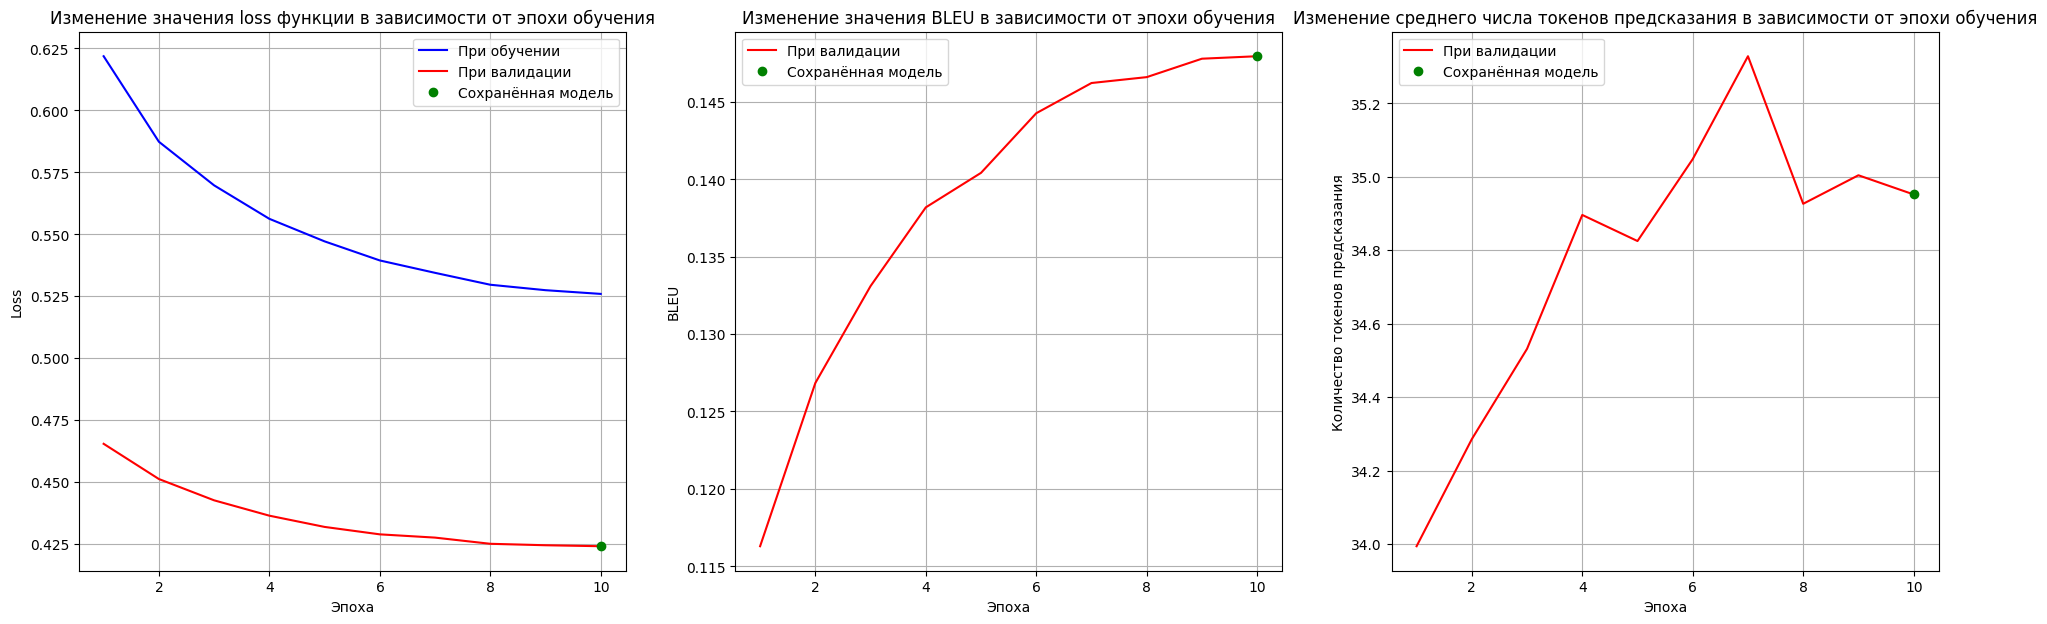

In [30]:
plot_history(history)